# 6.3 순환 신경망의 고급 사용법

이 절에서는 순환 신경망의 고급 사용법을 기온 예측 문제를 통해 설명함

### 순환 신경망의 성능과 일반화 능력을 향상시키기 위한 3가지 고급 기법

1. **순환 드롭아웃(recurrent dropout)**

    순환 층에서 overfitting을 방지


2. **스태킹 순환 층(stacking recurrent layer)**

    네트워크의 표현 능력(representation power)을 증가시킴(계산비용도 증가)


3. **양방향 순환 층(bidirectional recurrent layer)**

    정확도를 높이고 기억을 좀 더 오래 유지시킴

## 6.3.1 기온 예측 문제

- 날씨 시계열 데이터셋
    - `$ wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip`
- 마지막 데이터 포인트에서 24시간 이후의 온도를 예측하는 문제
- 시계열 데이터에서 일반적으로 나타나는 여러가지 어려운 점을 가지고 있음

In [1]:
# 데이터셋 분석

import os 

data_dir = './datasets/climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')


# f = open(fname)
# data = f.read()
# f.close()
with open(fname) as f:
    data = f.read()
    

lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]

print("총 데이터 수 :", len(lines))
print(headers)

총 데이터 수 : 420551
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [2]:
# numpy array로 바꾸기

import numpy as np

# "Date Time" column 제외
float_data = np.zeros((len(lines), len(headers)-1))

for i, line in enumerate(lines):
    float_data[i, :] = [float(x) for x in line.split(',')[1:]]
    
print(float_data.shape)
print(float_data[0])

(420551, 14)
[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


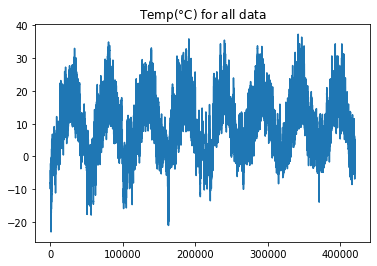

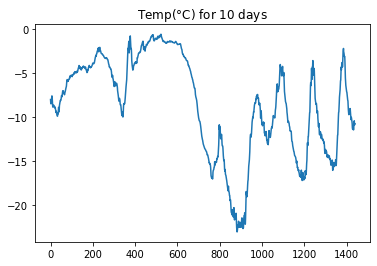

In [3]:
# 온도(섭씨) 데이터 그래프 그리기

import matplotlib.pyplot as plt

# 전체 온도 데이터
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.title("Temp($\degree$C) for all data")

plt.figure()

# 첫 10일간의 온도
temp = float_data[:1440, 1]
plt.plot(range(len(temp)), temp)
plt.title("Temp($\degree$C) for 10 days")

plt.show()

#### 그래프 분석
- 전체 데이터
    - 연간 온도에 주기성이 있고 안정적임
    - **연간 데이터는 안정적이므로 지난 몇 달간의 데이터로 다음 달의 평균 온도를 예측하기는 쉬움**
- 10일간 데이터
    - 일별 온도에 주기성이 있지만 불안정함(마지막 4일간만 그나마 안정적으로 보임)
    - **일간 데이터는 불안정적이므로 다음 날의 온도 예측은 어려움**

## 6.3.2 데이터 준비

기온 예측 문제를 정확히 정의하면 다음과 같음

> 10일간의 데이터를 바탕으로 다음 날(11일 째)의 온도를 예측하기

위 문제를 3가지 변수를 통해 다시 정의하면 다음과 같음

> `lookback` 타임스텝만큼 이전으로 돌아가서 매 `steps` 타임스텝마다 샘플링을 하고 이를 바탕으로 `delay` 타임스텝 이후의 온도를 예측하기
- `lookback=1440` : 10일 전
- `steps=6` : 1시간 간격으로 데이터 포인트를 샘플링
- `delay=144` : 24시간이 지난 데이터가 타깃


### 데이터 전처리

위에서 정확히 정의한 문제를 처리하기 위해 해야할 2가지 데이터 전처리

1. 데이터 정규화
    - 이미 수치형으로 되어있으므로 벡터화는 불필요
    - 각 feature별 데이터 스케일만 정규화해주면 됨(표준정규분포 형태로)
    
    
2. 원하는 형태로의 데이터 주입을 위한 파이썬 제너레이터

In [4]:
# 1. 데이터 정규화

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(float_data2)
# print(scaler.mean_)
# print(scaler.std_)
# scaler.transform(float_data2)
# print(float_data2[0])

In [5]:
# 2. 파이썬 제너레이터

def generator(data, lookback, delay, step=6, 
              shuffle=False, batch_size=128):
    min_idx = 0
    max_idx = len(data)-delay-1
    
    i = min_idx + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(i, max_idx, batch_size)
        else:
            if (i+batch_size) >= max_idx:
                rows = np.arange(i, max_idx)
                i = min_idx + lookback
                
            else:
                rows = np.arange(i, i+batch_size)
                i += batch_size
                
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            samples[j] = data[range(rows[j]-lookback, rows[j], step)]
            targets[j] = data[rows[j]+delay][1]
            
        yield samples, targets

In [6]:
lookback = 1440 
delay = 144
step = 6
batch_size = 128

train_gen = generator(float_data[:200000],
                      lookback=lookback,
                      delay=delay,
                      step=step,
                      shuffle=True,
                      batch_size=batch_size)

val_gen = generator(float_data[200000:300000],
                    lookback=lookback,
                    delay=delay,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data[300000:],
                     lookback=lookback,
                     delay=delay,
                     step=step,
                     batch_size=batch_size)

val_steps = int(np.ceil((300000-200000-lookback-delay-1)/batch_size))
test_steps = int(np.ceil((len(float_data)-300000-lookback-delay-1)/batch_size))

print(val_steps, test_steps)

769 930


## 6.3.3 상식 수준의 기준점

- 머신러닝 모델이 잘 동작하는지 평가하기 위한 최소한의 기준으로 상식 수준의 기준점을 만듦


- 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정하면(오늘 온도는 내일 온도와 비슷함) 아래와 같이 기준을 잡을 수 있음

> 24시간 후의 온도는 현재의 온도와 같다

- 위 기준에 대해 평균 절댓값 오차(MAE)로 평가

In [7]:
# 상식 기준의 mae 계산

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(targets - preds))
        batch_maes.append(mae)
    
    return (np.mean(batch_maes))

print("MAE :", evaluate_naive_method())

# 정규화 된 데이터라서 와닿지 않으므로 온도의 표준편차를 곱해줌
# 평균 절댓값 오차 : 약 섭씨 2.56도 정도
print("MAE(섭씨) :", evaluate_naive_method()*std[1])

MAE : 0.2897150610944221
MAE(섭씨) : 2.564702312439227


- 따라서 우리가 만들 머신러닝 모델은 2.56도의 오차보다 더 적은 온도차를 예측해야함

## 6.3.4 기본적인 머신 러닝 방법

### 간단한 머신러닝 모델

- RNN과 같은 복잡하고 연산비용이 많이 드는 모델을 바로 시도하기 전에 간단하고 쉬운 머신러닝 모델(FCN)을 만들어 테스트 해보는 것이 좋음


- 이는 복잡한 모델을 도입하는 근거를 마련해주기 때문(굳이 안복잡해도 되는데 복잡하게 접근하는 경우가 생길 수 있음)


- 손실함수는 MAE로 상식 수준의 모델과 비교할 수 있게 설정

In [10]:
from tensorflow.python import keras
from keras import models
from keras import layers

input_shape = (lookback//step, float_data.shape[-1])

model = models.Sequential()

model.add(layers.Flatten(input_shape=input_shape))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='mae',
              optimizer='rmsprop')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s 15ms/step - loss: 1.2650 - val_loss: 0.4410
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.3783 - val_loss: 0.2778
Epoch 3/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2805 - val_loss: 0.2151
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2616 - val_loss: 0.2671
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2512 - val_loss: 0.1965
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2419 - val_loss: 0.2150
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2376 - val_loss: 0.1995
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2305 - val_loss: 0.1863
Epoch 9/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2253 - val_loss: 0.3041
Epoch 10/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2221 - val_lo

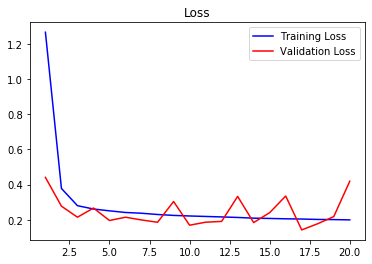

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.show()

#### 결과 분석
- 기준점 MAE(약 0.28)보다 적은 검증 손실(MAE)(최소 0.1429)을 보이지만 불안정함
- 큰 성능 차이는 보이지 못함


#### 상식 수준의 기준 모델보다 큰 차이를 보이지 못하는 이유
- 모델의 가설 공간은 매우 복잡함
- 학습 알고리즘이 특정 종류의 간단한 모델을 찾도록 하드코딩 된 것이 아니라면 상식 수준의 방법과 같은 간단한 해결책은 찾지 못할 수 있음(이것이 일반적으로 머신러닝이 가진 심각한 제약사항)

## 6.3.5 첫 번째 순환 신경망

- 6.3.4절의 간단한 머신러닝 모델은 잘 동작하지 않았음(시간 개념을 고려 X)
- 시간 개념을 고려하는 순환 시퀀스 처리 모델로 다시 시도


- LSTM 대신에 GRU로 시도 (LSTM이 더 표현학습 능력이 좋아서 잘 될수도 있음(계산비용과 표현학습능력 사이의 trade-off))

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()

model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 79s 158ms/step - loss: 0.3089 - val_loss: 0.1488
Epoch 2/20
500/500 [==============================] - 79s 158ms/step - loss: 0.2866 - val_loss: 0.1425
Epoch 3/20
500/500 [==============================] - 80s 159ms/step - loss: 0.2774 - val_loss: 0.1368
Epoch 4/20
500/500 [==============================] - 79s 157ms/step - loss: 0.2729 - val_loss: 0.1554
Epoch 5/20
500/500 [==============================] - 79s 157ms/step - loss: 0.2680 - val_loss: 0.1660
Epoch 6/20
500/500 [==============================] - 78s 157ms/step - loss: 0.2661 - val_loss: 0.1751
Epoch 7/20
500/500 [==============================] - 79s 158ms/step - loss: 0.2618 - val_loss: 0.1356
Epoch 8/20
500/500 [==============================] - 80s 160ms/step - loss: 0.2579 - val_loss: 0.1492
Epoch 9/20
500/500 [==============================] - 80s 160ms/step - loss: 0.2535 - val_loss: 0.1936
Epoch 10/20
500/500 [==============================] - 80s 159ms/step - l

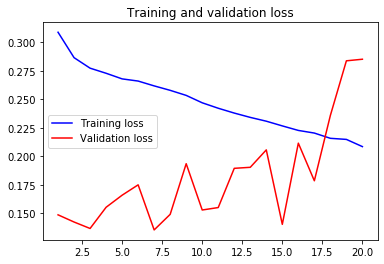

In [11]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 결과 분석
- 간단한 머신러닝 모델의 MAE(최소 0.1429)보다 적은 검증 손실(MAE)(0.1356)을 보였음
- Overfitting이 일어남

## 6.3.6 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

### 순환 신경망의 Dropout

**순환 층에 dropout을 적용하려면, 모든 타임스텝에 동일한 dropout mask를 적용해야 함** (순환 층 이전에 dropout을 적용하면 regularization을 통한 도움보다 학습에 더 방해가 됨)

이는 순환층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 dropout mask를 적용해야 한다는 것을 뜻하며 모든 타임스텝에 동일한 dropout mask가 적용되면 네트워크가 오차를 타임스텝에 걸쳐서 적절하게 전파시키게 됨

### 케라스의 2가지 순환 층 Dropout 

케라스의 모든 순환층에서는 2개의 매개변수로 이를 적용할 수 있음

- `dropout`
    - 층의 입력에 대한 dropout 비율
    - LSTM과 GRU의 pseudo code에서 `input_t`
- `recurrent_dropout`
    - 순환 상태의 dropout 비율
    - LSTM과 GRU의 pseudo code에서 `state_t`
    


- 주의) LSTM의 경우, 아래 pseudo code에서 4개(`output_t`, `i_t`, `f_t`, `k_t`)의 `input_t`, `state_t`에 각기 다른 dropout mask가 적용됨
~~~
output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)
i_t = activation(dot(input_t, Wi) + dot(state_t, Ui) + bi)
f_t = activation(dot(input_t, Wf) + dot(state_t, Uf) + bf)
k_t = activation(dot(input_t, Wk) + dot(state_t, Uk) + bk)
~~~

- 주의) GRU의 경우, 아래 pseudo code에서 3개(`z_t`, `r_t`, `g_t`)의 
`input_t`, `state_t`에 각기 다른 dropout mask가 적용됨 (`output_t`의 `state_t`에는 dropout mask 미적용)

~~~
output_t = z_t x state_t + (1 - z_t) x g_t

z_t = sigmoid(dot(state_t, Uz) + dot(input_t, Wz) + bz)
r_t = sigmoid(dot(state_t, Ur) + dot(input_t, Wr) + br)
g_t = tanh(dot(r_t x state_t, Ug) + dot(input_t, Wg) + bg)
~~~

In [7]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()

model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=optimizers.RMSprop(), loss='mae')

# dropout을 적용한 network의 경우, 수렴하는데 오래 걸리므로, epoch을 두배로 늘렸음
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()